In [4]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
from analysis.lib.purification import purify_pq as ppq; reload(ppq)
%matplotlib inline
is_remote_lt3_measurement = False
# folder=tb.latest_data('lt3_SPCORR')\
tag = 'LT3'
folder=tb.latest_data(tag)
lt3_folder=tb.latest_data(tag, folder ='Z:\data')
#folder = r'D:\measuring\data\20151127\110547_Bell_lt3_SPCORR_ZPL_SPCORR_lt3'
print 'folder :', folder
print 'lt3_folder', lt3_folder
name = 'ssro'
a = ppq.purify_pq(folder, hdf5_mode='r')#, pq_folder='bs_remote')
b = ppq.purify_pq(lt3_folder, hdf5_mode='r')#, pq_folder='bs_remote')

d:\measuring\data
folder : d:\measuring\data\20160807\135031_Purification_111no2_SIL2_SPCorrs_ZPL_LT3
lt3_folder Z:\data\20160807\135023_Purification_Pippin_SIL2_SPCorrs_ZPL_LT3


The number of markers is: 2000
The number of markers is: 2000


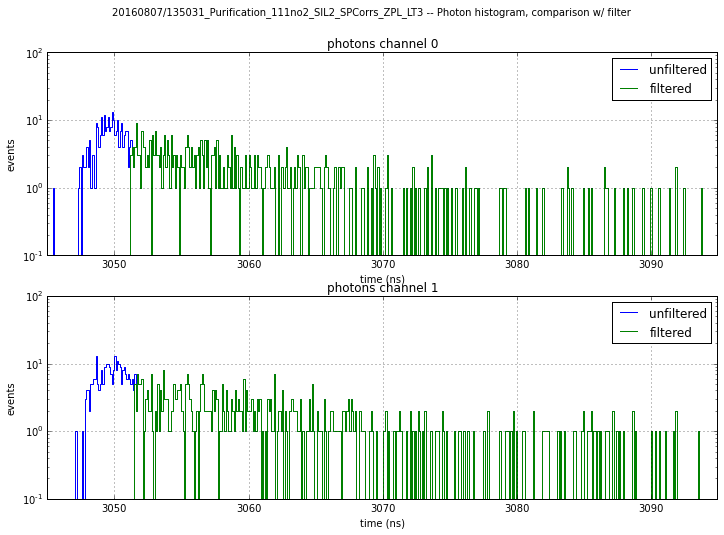

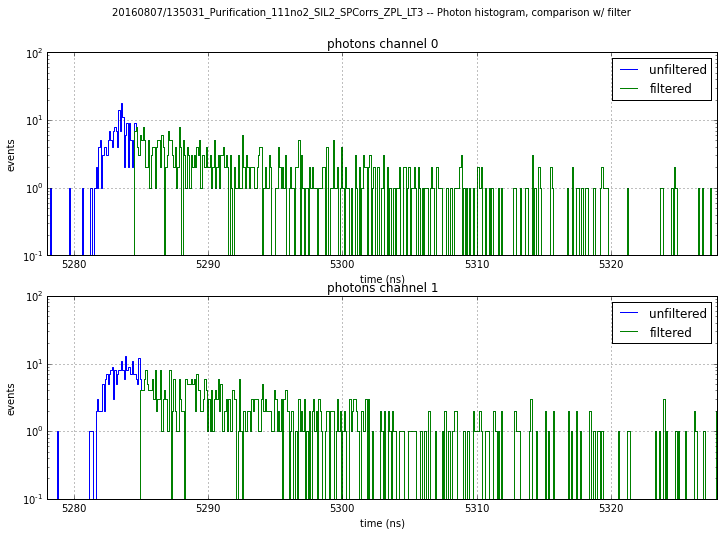

In [5]:
pq_plots.plot_marker_filter_comparison(a.pqf,
                          mrkr_chan = 1,
                          start = 3.045E6,#+2.23e6, #settings.bs_process_params['st_start_ch0'],  
                          length= 0.05E6,#settings.bs_process_params['st_len']+settings.bs_process_params['pulse_sep'], 
                          hist_binsize = 100,save = False,log=True)
pq_plots.plot_marker_filter_comparison(a.pqf,
                          mrkr_chan = 1,
                          start = 3.045E6+2233e3,#+2.23e6, #settings.bs_process_params['st_start_ch0'],  
                          length= 0.05E6,#settings.bs_process_params['st_len']+settings.bs_process_params['pulse_sep'], 
                          hist_binsize = 100,save = False,log=True)

In [3]:
sp_lt = a.pqf['/PQ_special-1'].value # Special: marker channel
ch_lt = a.pqf['/PQ_channel-1'].value # Channel: photon channel
sn_lt = a.pqf['/PQ_sync_number-1'].value # Sync number: the number of the last sync signal
st_lt = a.pqf['/PQ_sync_time-1'].value # Sync time: time that has passed since the last sync signal
#tt_lt = a.pqf['/PQ_time-1'].value 

In [478]:
photon_channel = 2 # 0 or 1; 2 means both HH detectors
st_start = 3054e3 #1975e3+500e3#2763e3
st_len       = 40e3 #50 ns
st_len_w2    = 40e3
#p_sep       = 2500e3 #600 ns
p_sep        = 2233e3#2732e3 #XXX why has this changed?

In [479]:
### filter the PQ data: Return an array which is True at each position where an event was in a window
if (photon_channel == 0) or (photon_channel == 1):
    st_fltr_w1 = (ch_lt == photon_channel)  & (st_lt > st_start)  & (st_lt < (st_start  + st_len)) & (sp_lt ==0)
    st_fltr_w2 = (ch_lt == photon_channel)  & (st_lt > st_start + p_sep)  & (st_lt < (st_start + p_sep + st_len_w2)) & (sp_lt ==0)
else:
    st_fltr_w1 = (st_lt > st_start)  & (st_lt < (st_start  + st_len)) & (sp_lt == 0)
    st_fltr_w2 = (st_lt > st_start + p_sep)  & (st_lt < (st_start + p_sep + st_len_w2)) & (sp_lt == 0)
#fltr_ro    = (sp_lt == 0) & (ch_lt == ro_channel)  & (st_lt > ro_start)  & (st_lt < (ro_start  + ro_length))   
print len(sn_lt[st_fltr_w1])
print len(sn_lt[st_fltr_w2])

712
824


In [480]:
### filter the adwin RO data according to the now filtered pq data
noof_reps = len(np.unique(sn_lt))
w1_sn = sn_lt[st_fltr_w1]
w2_sn = sn_lt[st_fltr_w2]
noof_w1 = np.sum(st_fltr_w1)
noof_w2 = np.sum(st_fltr_w2)
print noof_w1,noof_w2

if is_remote_lt3_measurement:
    print 'using lt3 file'
    adwin_filter_w1 = b.filter_adwin_data_from_pq_syncs(w1_sn)
    print len(adwin_filter_w1[0])
    adwin_filter_w2 = b.filter_adwin_data_from_pq_syncs(w2_sn)
    print len(adwin_filter_w2[0])
    noof_reps2= b.agrp['completed_reps'].value*b.g['joint_params'].attrs['LDE1_attempts']
    noof_w1_ro0 = np.sum(b.agrp['ssro_results'].value[adwin_filter_w1[0]])
    noof_w2_ro0 = np.sum(b.agrp['ssro_results'].value[adwin_filter_w2[0]])
    print len(b.filter_adwin_data_from_pq_syncs(w1_sn)[1]), len(b.filter_adwin_data_from_pq_syncs(w2_sn)[1])
else:
    adwin_filter_w1 = a.filter_adwin_data_from_pq_syncs(w1_sn)
    adwin_filter_w2 = a.filter_adwin_data_from_pq_syncs(w2_sn)
    noof_reps2= a.agrp['completed_reps'].value*a.g['joint_params'].attrs['LDE1_attempts']
    noof_w1_ro0 = np.sum(a.agrp['ssro_results'].value[adwin_filter_w1[0]])
    noof_w2_ro0 = np.sum(a.agrp['ssro_results'].value[adwin_filter_w2[0]])
    print len(a.filter_adwin_data_from_pq_syncs(w1_sn)[1]), len(a.filter_adwin_data_from_pq_syncs(w2_sn)[1])

712 824
712 824


In [481]:
print noof_reps,noof_reps2, noof_w1_ro0, noof_w2_ro0, noof_w1, noof_w2
print 'missed syncs', float(noof_reps)/noof_reps2
print 'tail_cts', float(noof_w1+noof_w2)/noof_reps2*1e4
print "RO's", noof_w1_ro0,noof_w2_ro0

3263 500000 10 762 712 824
missed syncs 0.006526
tail_cts 30.72
RO's 10 762


In [482]:
reload(ppq)

if is_remote_lt3_measurement == True:  
    ssro_calib_folder  = tb.latest_data('SSROCalib', folder ='Z:\data')
    ro_time = b.agrp.attrs['E_RO_durations'][0]
else:
    ssro_calib_folder  = tb.latest_data('SSROCalib')
    ro_time = a.agrp.attrs['E_RO_durations'][0]
#sweep_index , what does it do??

if is_remote_lt3_measurement:
    trans = 'msp1'
else:
    trans = None
    
ssro_fids = ppq.get_analysed_fast_ssro_calibration(ssro_calib_folder,e_transition = trans, readout_time = ro_time)

10 712
0.0140449438202 0.924757281553 0.0044101013029 0.00918930175302


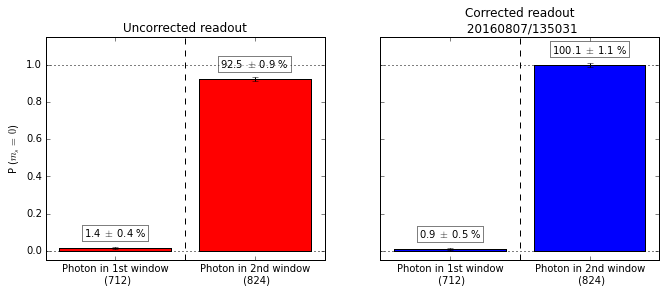

In [483]:
# P_ms1 generally stands for the probability to measure ms=1
# P_photon is the probability for getting a photon
win1_P_photon = float(noof_w1_ro0)/noof_w1
u_win1_P_photon = np.sqrt(win1_P_photon * (1.-win1_P_photon)/noof_w1)

win2_P_photon = float(noof_w2_ro0)/noof_w2
u_win2_P_photon = np.sqrt(win2_P_photon * (1.-win2_P_photon)/noof_w2)
print noof_w1_ro0, noof_w1
print win1_P_photon,win2_P_photon, u_win1_P_photon, u_win2_P_photon
fig, (ax, ax_corr) = plt.subplots(1,2, figsize=(11,4),
                              sharex=True, sharey=True)

### uncorrected for e-SSRO
ax.bar(range(2), [win1_P_photon, win2_P_photon], color=['r', 'r'],
       align='center', yerr=[u_win1_P_photon, u_win2_P_photon], ecolor='k',
       width=0.8)

ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.05, 1.15)

ax.set_ylabel('P ($m_s =\, 0$)')

ax.set_xticks([0,1])
ax.set_xticklabels(['Photon in 1st window \n ({})'.format(noof_w1),
                    'Photon in 2nd window \n ({})'.format(noof_w2)])
ax.axvline(0.5, c='k', ls='--')
ax.axhline(0, c='k', ls=':')
ax.axhline(1, c='k', ls=':')

ax.text(0, win1_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P_photon*100, u_win1_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.text(1, win2_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P_photon*100, u_win2_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.set_title('Uncorrected readout')

### corrected for e-SSRO
win1_P0, u_win1_P0 = roc.single_qubit_outcome_with_ROC_from_fraction(win1_P_photon, u_win1_P_photon, 
                                                                     *ssro_fids)
win2_P0, u_win2_P0 = roc.single_qubit_outcome_with_ROC_from_fraction(win2_P_photon, u_win2_P_photon,
                                                                     *ssro_fids)

ax_corr.bar(range(2), [win1_P0, win2_P0], color=['b','b'],
       align='center', yerr=[u_win1_P0, u_win2_P0], ecolor='k',
       width=0.8)
ax_corr.axvline(0.5, c='k', ls='--')
ax_corr.axhline(0, c='k', ls=':')
ax_corr.axhline(1, c='k', ls=':')

ax_corr.text(0, win1_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P0*100, u_win1_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.text(1, win2_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P0*100, u_win2_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.set_title('Corrected readout \n '+a.timestamp)
fig.savefig(os.path.join(folder, 'Spin-photon_correlations.png'))

In [468]:
hist(st_lt[fltr_ro][np.in1d(ro0_sn,w2_sn)])

In [446]:
print 'PSB SP corr from date : {}'.format(tb.get_plot_title_from_folder(folder)[:15])
print '\tTail counts : {:.1f} '. format(float(noof_w1+noof_w2)/noof_reps*1e4)
print '\tRatio of photons detected in w1/w2 : {:.1f} %'.format(np.float(noof_w1)/noof_w2*100)
print '\tUncorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P_photon*100, u_win1_P_photon*100,win2_P_photon*100, u_win2_P_photon*100)
print '\tCorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P0*100, u_win2_P0*100,win2_P0*100, u_win2_P0*100)
if win1_P_photon*100 <2.5 and win2_P_photon*100>93.5 and np.float(noof_w1)/noof_w2*100 > 94 and np.float(noof_w1)/noof_w2*100<106:
    print 'all thresholds (93.5 and 2.5 and 94:106) are met.'
else:
    print 'threasholds are NOT met. Compare to threashold: 93.5 and 2.5 and 94:106'

PSB SP corr from date : 20160805/101823
	Tail counts : 3719.1 
	Ratio of photons detected in w1/w2 : 83.8 %
	Uncorrected readout : W1 : 0.8 +/- 0.4 % & W2 : 90.6 +/- 1.4 %
	Corrected readout : W1 : 0.2 +/- 1.6 % & W2 : 99.0 +/- 1.6 %
threasholds are NOT met. Compare to threashold: 93.5 and 2.5 and 94:106


In [424]:
#JB
# The sync number identifies detector clicks that were measured in the same trial
# Create a filter that selects all detector clicks from the PSB channel when the laser was on
fltr_PBS_laserOn = (sp_lt == 0) & (ch_lt == 0) & (st_lt > 7573) & (st_lt < 7660)
# Create a filter that selects all detector clicks from the ZPL channel when the laser was off
fltr_ZPL_laserOff = (sp_lt == 0) & (ch_lt == 1) & (st_lt > 7603) & (st_lt < 7630)
# Retreive sync number for detector clicks that pass filter 1
sn_PBS_laserOn = sn_lt[fltr_PBS_laserOn]
# Retreive sync number for detector clicks that pass filter 2
sn_ZPL_laserOff =sn_lt[fltr_ZPL_laserOff]
# Find sync numbers that occur in both groups
sn_filtered = sn_PBS_laserOn[np.in1d(sn_PBS_laserOn, sn_ZPL_laserOff)]
print 'Total number of detector clicks:', len(fltr_PBS_laserOn)
print 'Total number of trials:', len(np.unique(sn_lt))
print 'Trials with a click on PBS channel while laser is on:', len(np.unique(sn_PBS_laserOn)), '(', (1.0 * len(np.unique(sn_PBS_laserOn))) / len(np.unique(sn_lt)) * 100, '%)'
print 'Trials with a click on ZPL channel while laser is off:', len(np.unique(sn_ZPL_laserOff)), '(', (1.0 * len(np.unique(sn_ZPL_laserOff))) / len(np.unique(sn_lt)) * 100, '%)'
print 'Trials with both a PBS photon with laser on and a ZPL photon with laser off:', len(sn_filtered) 

Total number of detector clicks: 4209
Total number of trials: 2207
Trials with a click on PBS channel while laser is on: 0 ( 0.0 %)
Trials with a click on ZPL channel while laser is off: 0 ( 0.0 %)
Trials with both a PBS photon with laser on and a ZPL photon with laser off: 0
